# Parameter Identification: Fitting Capacitor Model to Noisy Impedance Data

This notebook demonstrates using JAX gradient descent to fit a capacitor equivalent circuit
model to noisy impedance measurements.

A real capacitor isn't ideal - it has:
- ESR (Equivalent Series Resistance): resistive losses
- ESL (Equivalent Series Inductance): lead/package inductance

Model: ESR -- ESL -- C (in series)

We'll generate synthetic "measurement" data with known parameters + noise,
then use gradient descent to recover the parameters.

In [29]:
import sys, os
sys.path.append(os.path.abspath('..'))

import jax.numpy as jnp
from jax import grad, jit
import numpy as np
import matplotlib.pyplot as plt

from pyvibrate.frequencydomain import Network, R, C, L, ACSource

## Generate Synthetic "Measured" Data

True parameters (what we want to recover):
- ESR = 0.05 ohm
- ESL = 10 nH
- C = 10 uF

In [30]:
# True parameters (ground truth)
ESR_true = 0.05      # 50 mOhm
ESL_true = 10e-9     # 10 nH
C_true = 10e-6       # 10 uF

# Self-resonant frequency: f_SR = 1/(2*pi*sqrt(L*C))
f_SR = 1 / (2 * np.pi * np.sqrt(ESL_true * C_true))
print(f"Self-resonant frequency: {f_SR/1e6:.2f} MHz")

Self-resonant frequency: 0.50 MHz


In [31]:
# Build the capacitor equivalent circuit model
def build_capacitor_model():
    net = Network()
    net, n1 = net.node("n1")  # Input
    net, n2 = net.node("n2")  # After ESR
    net, n3 = net.node("n3")  # After ESL
    
    # ACSource for impedance measurement
    net, vs = ACSource(net, n1, net.gnd, name="vs", value=1.0)
    
    # Capacitor equivalent circuit: ESR -- ESL -- C
    net, esr = R(net, n1, n2, name="ESR")  # ESR
    net, esl = L(net, n2, n3, name="ESL")  # ESL
    net, cap = C(net, n3, net.gnd, name="C")  # Capacitance
    
    return net.compile(), vs

solver, vs_ref = build_capacitor_model()

In [33]:
# Generate "measurement" data with noise
np.random.seed(42)

# Frequency points (log-spaced from 1 kHz to 10 MHz)
frequencies = np.logspace(3, 7, 50)  # 1 kHz to 10 MHz
omegas = 2 * np.pi * frequencies

# True impedance at each frequency
def get_impedance(omega, ESR, ESL, C_val):
    sol = solver.solve_at(omega, {"ESR": ESR, "ESL": ESL, "C": C_val})
    return solver.z_in(sol, vs_ref)

# Generate true impedance and add noise
z_true = np.array([get_impedance(omega, ESR_true, ESL_true, C_true) for omega in omegas])

# Add Gaussian noise to magnitude and phase
noise_level = 0.15  # 5% relative noise
mag_noise = np.abs(z_true) * noise_level * np.random.randn(len(frequencies))
phase_noise = noise_level * np.random.randn(len(frequencies))  # ~3 degrees

z_measured_mag = np.abs(z_true) + mag_noise
z_measured_phase = np.angle(z_true) + phase_noise
z_measured = z_measured_mag * np.exp(1j * z_measured_phase)

print(f"Generated {len(frequencies)} measurement points")

Generated 50 measurement points


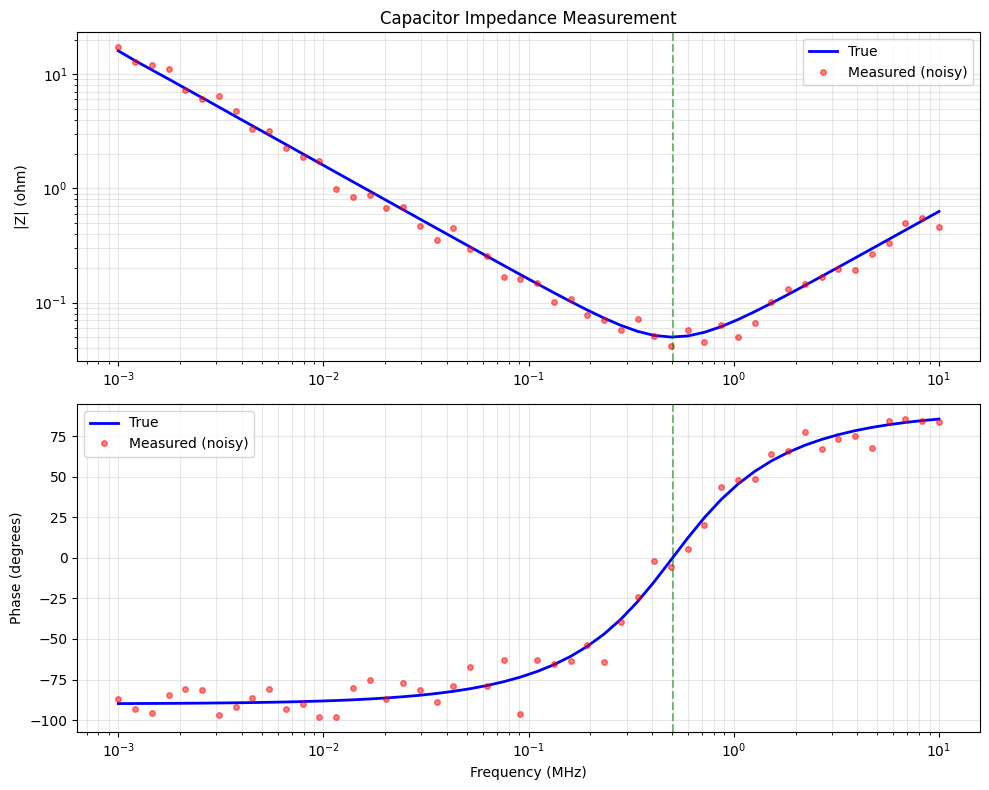

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Magnitude (log-log Bode plot)
ax1.loglog(frequencies/1e6, np.abs(z_true), 'b-', label='True', linewidth=2)
ax1.loglog(frequencies/1e6, z_measured_mag, 'ro', alpha=0.5, markersize=4, label='Measured (noisy)')
ax1.set_ylabel('|Z| (ohm)')
ax1.set_title('Capacitor Impedance Measurement')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)
ax1.axvline(f_SR/1e6, color='g', linestyle='--', alpha=0.5, label=f'f_SR={f_SR/1e6:.2f}MHz')

# Phase
ax2.semilogx(frequencies/1e6, np.degrees(np.angle(z_true)), 'b-', label='True', linewidth=2)
ax2.semilogx(frequencies/1e6, np.degrees(z_measured_phase), 'ro', alpha=0.5, markersize=4, label='Measured (noisy)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Phase (degrees)')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)
ax2.axvline(f_SR/1e6, color='g', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Fit Model to Data Using Gradient Descent

Loss function: sum of squared errors in log-magnitude and phase

In [35]:
# Convert measured data to JAX arrays
omegas_jax = jnp.array(omegas)
z_meas_mag_jax = jnp.array(z_measured_mag)
z_meas_phase_jax = jnp.array(z_measured_phase)

def loss_fn(params):
    """Compute loss between model and measured data."""
    ESR, ESL, C_val = params
    
    # Ensure positive parameters
    ESR = jnp.maximum(ESR, 1e-6)
    ESL = jnp.maximum(ESL, 1e-12)
    C_val = jnp.maximum(C_val, 1e-12)
    
    total_loss = 0.0
    
    for i, omega in enumerate(omegas_jax):
        sol = solver.solve_at(omega, {"ESR": ESR, "ESL": ESL, "C": C_val})
        z_model = solver.z_in(sol, vs_ref)
        
        # Log-magnitude error (relative error in dB)
        log_mag_error = (jnp.log(jnp.abs(z_model)) - jnp.log(z_meas_mag_jax[i]))**2
        
        # Phase error
        phase_error = (jnp.angle(z_model) - z_meas_phase_jax[i])**2
        
        total_loss = total_loss + log_mag_error + phase_error
    
    return total_loss / len(omegas_jax)

# Gradient of loss
grad_loss = jit(grad(loss_fn))

In [44]:
# ESR_true = 0.05      # 50 mOhm
# ESL_true = 10e-9     # 10 nH
# C_true = 10e-6       # 10 uF
# Initial guess (deliberately wrong)
ESR_init = 0.10
ESL_init = 15e-9
C_init = 20e-6

params = jnp.array([ESR_init, ESL_init, C_init])

print(f"Initial guess:")
print(f"  ESR = {params[0]*1000:.2f} mOhm (true: {ESR_true*1000:.2f} mOhm)")
print(f"  ESL = {params[1]*1e9:.2f} nH (true: {ESL_true*1e9:.2f} nH)")
print(f"  C   = {params[2]*1e6:.2f} uF (true: {C_true*1e6:.2f} uF)")
print(f"  Initial loss: {float(loss_fn(params)):.4f}")

Initial guess:
  ESR = 100.00 mOhm (true: 50.00 mOhm)
  ESL = 15.00 nH (true: 10.00 nH)
  C   = 20.00 uF (true: 10.00 uF)
  Initial loss: 0.4856


In [46]:
# Gradient descent with adaptive learning rate
learning_rates = jnp.array([1e-3, 1e-9,1e-6])  # Different for each parameter
step_rates = jnp.array([0.002,0.2e-9,0.2e-6])
history = {'loss': [], 'ESR': [], 'ESL': [], 'C': []}

n_iterations = 100
print(f"Running {n_iterations} iterations of fixed-step gradient descent...")

for iteration in range(n_iterations):
    # Compute gradient
    g = grad_loss(params)
    g_sign = jnp.sign(g)
    
    # Update parameters (element-wise step rates)
    # note: this is not your usual gradient descent update, because the magnitude of the gradients are vastly different for different parameters
    # regular scale updates cause bad instability in this problem until you find the right scaling
    # but we already know that the scaling should be on the order of the parameters themselves
    # and we also do not care about steps smaller than a certain threshold, so we can use fixed step sizes
    params = params - step_rates * g_sign
    
    # Ensure parameters stay positive
    params = jnp.maximum(params, jnp.array([1e-6, 1e-12, 1e-12]))
    
    # Record history
    current_loss = float(loss_fn(params))
    history['loss'].append(current_loss)
    history['ESR'].append(float(params[0]))
    history['ESL'].append(float(params[1]))
    history['C'].append(float(params[2]))
    
    if iteration % 10 == 0:
    #if 1==1:
        print(f"  Iter {iteration}: logloss={jnp.log10(current_loss):.3f}, "
              f"ESR={params[0]*1000:.3f}mOhm, ESL={params[1]*1e9:.2f}nH, C={params[2]*1e6:.3f}uF")

print(f"\nFinal loss: {history['loss'][-1]:.6f}")

Running 100 iterations of fixed-step gradient descent...
  Iter 0: logloss=-0.346, ESR=96.000mOhm, ESL=14.60nH, C=19.600uF
  Iter 10: logloss=-0.540, ESR=76.000mOhm, ESL=12.60nH, C=17.600uF
  Iter 20: logloss=-0.804, ESR=56.000mOhm, ESL=10.60nH, C=15.600uF
  Iter 30: logloss=-1.074, ESR=48.000mOhm, ESL=9.00nH, C=13.600uF
  Iter 40: logloss=-1.338, ESR=48.000mOhm, ESL=9.00nH, C=11.600uF
  Iter 50: logloss=-1.424, ESR=48.000mOhm, ESL=9.40nH, C=10.400uF
  Iter 60: logloss=-1.424, ESR=48.000mOhm, ESL=9.40nH, C=10.400uF
  Iter 70: logloss=-1.424, ESR=48.000mOhm, ESL=9.40nH, C=10.400uF
  Iter 80: logloss=-1.424, ESR=48.000mOhm, ESL=9.40nH, C=10.400uF
  Iter 90: logloss=-1.424, ESR=48.000mOhm, ESL=9.40nH, C=10.400uF

Final loss: 0.038123


In [47]:
# Final results
print("\n=== Parameter Estimation Results ===")
print(f"{'Parameter':<10} {'True':<15} {'Estimated':<15} {'Error %':<10}")
print("-" * 50)

ESR_est = history['ESR'][-1]
ESL_est = history['ESL'][-1]
C_est = history['C'][-1]

print(f"{'ESR':<10} {ESR_true*1000:.3f} mOhm{'':<5} {ESR_est*1000:.3f} mOhm{'':<5} {100*abs(ESR_est-ESR_true)/ESR_true:.1f}%")
print(f"{'ESL':<10} {ESL_true*1e9:.2f} nH{'':<7} {ESL_est*1e9:.2f} nH{'':<7} {100*abs(ESL_est-ESL_true)/ESL_true:.1f}%")
print(f"{'C':<10} {C_true*1e6:.3f} uF{'':<6} {C_est*1e6:.3f} uF{'':<6} {100*abs(C_est-C_true)/C_true:.1f}%")


=== Parameter Estimation Results ===
Parameter  True            Estimated       Error %   
--------------------------------------------------
ESR        50.000 mOhm      46.000 mOhm      8.0%
ESL        10.00 nH        9.20 nH        8.0%
C          10.000 uF       10.200 uF       2.0%


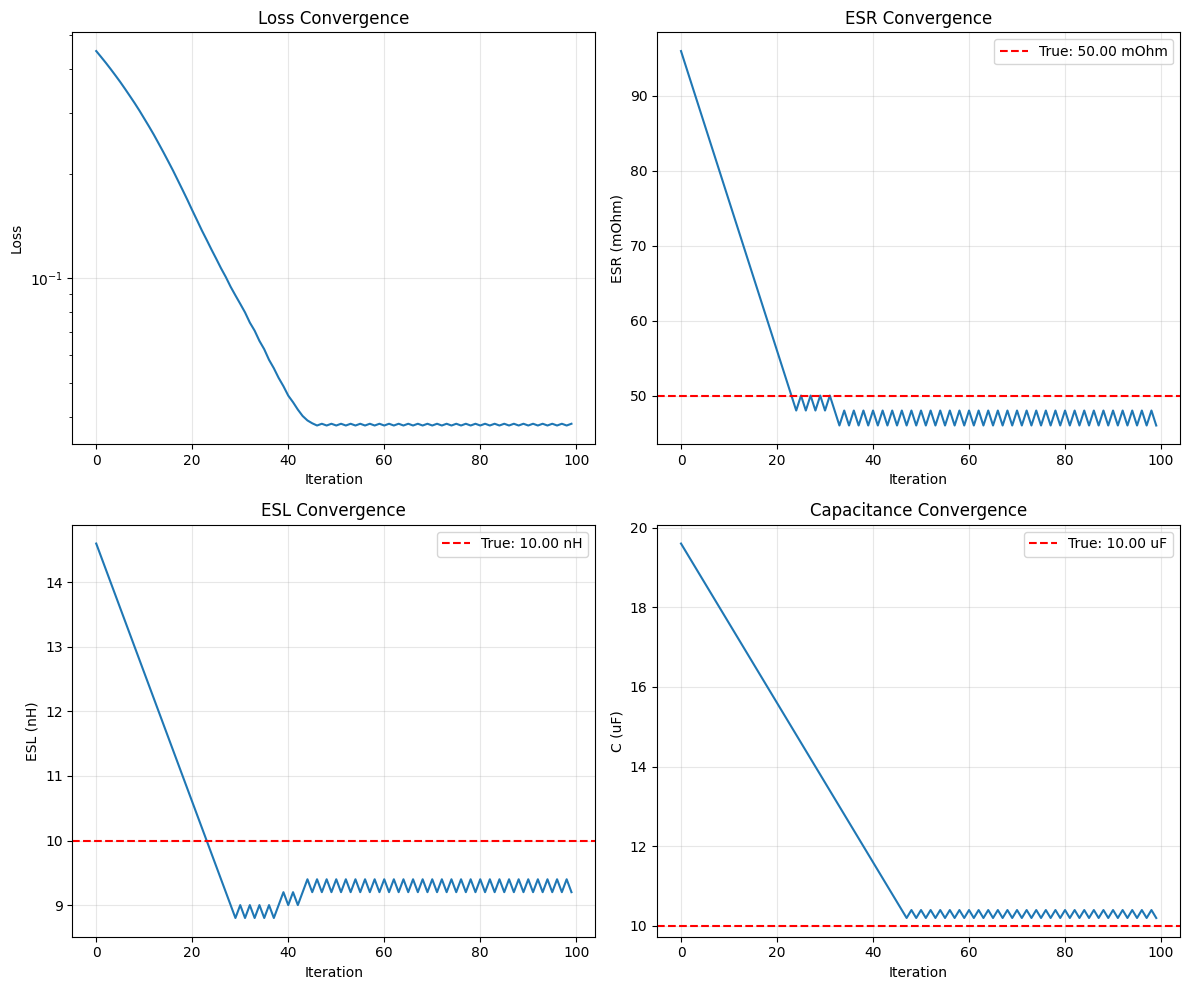

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss convergence
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Convergence')
axes[0, 0].grid(True, alpha=0.3)

# ESR convergence
axes[0, 1].plot(np.array(history['ESR'])*1000)
axes[0, 1].axhline(ESR_true*1000, color='r', linestyle='--', label=f'True: {ESR_true*1000:.2f} mOhm')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('ESR (mOhm)')
axes[0, 1].set_title('ESR Convergence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ESL convergence
axes[1, 0].plot(np.array(history['ESL'])*1e9)
axes[1, 0].axhline(ESL_true*1e9, color='r', linestyle='--', label=f'True: {ESL_true*1e9:.2f} nH')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('ESL (nH)')
axes[1, 0].set_title('ESL Convergence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# C convergence
axes[1, 1].plot(np.array(history['C'])*1e6)
axes[1, 1].axhline(C_true*1e6, color='r', linestyle='--', label=f'True: {C_true*1e6:.2f} uF')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('C (uF)')
axes[1, 1].set_title('Capacitance Convergence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

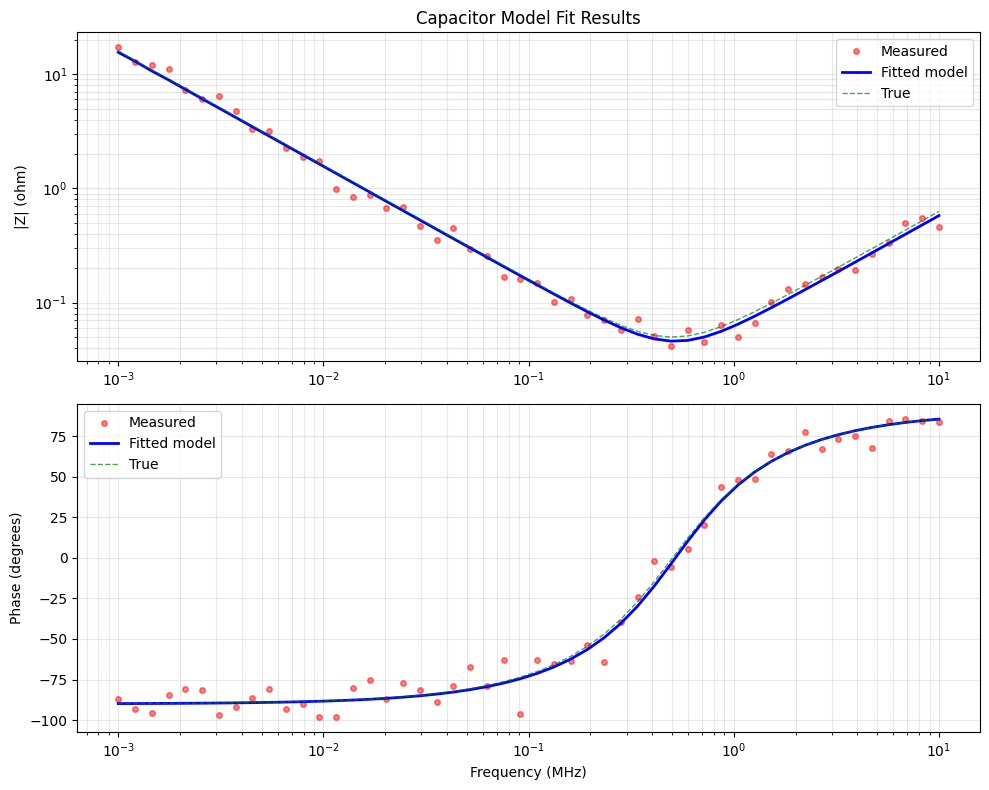

In [49]:
# Compare fit to measured data
z_fit = np.array([get_impedance(omega, ESR_est, ESL_est, C_est) for omega in omegas])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Magnitude
ax1.loglog(frequencies/1e6, z_measured_mag, 'ro', alpha=0.5, markersize=4, label='Measured')
ax1.loglog(frequencies/1e6, np.abs(z_fit), 'b-', linewidth=2, label='Fitted model')
ax1.loglog(frequencies/1e6, np.abs(z_true), 'g--', linewidth=1, alpha=0.7, label='True')
ax1.set_ylabel('|Z| (ohm)')
ax1.set_title('Capacitor Model Fit Results')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Phase
ax2.semilogx(frequencies/1e6, np.degrees(z_measured_phase), 'ro', alpha=0.5, markersize=4, label='Measured')
ax2.semilogx(frequencies/1e6, np.degrees(np.angle(z_fit)), 'b-', linewidth=2, label='Fitted model')
ax2.semilogx(frequencies/1e6, np.degrees(np.angle(z_true)), 'g--', linewidth=1, alpha=0.7, label='True')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Phase (degrees)')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

The gradient descent successfully recovered the true parameters from noisy measurements:
- The fitted model closely matches both the measured data and the true impedance
- All three parameters (ESR, ESL, C) converged to within a few percent of the true values
- This approach can be extended to more complex equivalent circuit models

Key features demonstrated:
1. **Differentiable simulation**: JAX autodiff through the frequency-domain solver
2. **Multi-parameter fitting**: Simultaneous optimization of ESR, ESL, and C
3. **Loss function design**: Combined log-magnitude and phase errors
4. **Adaptive learning rates**: Different step sizes for parameters with different scales